# Following models are tried out in the following code 


1.   Random Forest
2.   Linear SVC
3.   Multinomial NB
4.   Logistic Regression



#### Important files are imported

In [1]:
pip install "gensim==3.8.3"

In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [3]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.sklearn_api import TfIdfTransformer

In [4]:
combined = pd.read_csv('/content/drive/MyDrive/dataset_patent/generated_files/cleaned_data_150k.csv')

In [13]:
combined.head()

,text,target
46902,The above-described problems can be solved by ...,0
48139,"As described above, according to the present d...",1
37430,The invention can provide a light-shielding co...,1
102911,"Thus, an object of the present invention is to...",2
61284,Such conventional technologies of cultivating ...,2


In [40]:
def ChunkIterator():
    for chunk in pd.read_csv('/content/drive/MyDrive/dataset_patent/generated_files/cleaned_data_150k.csv', chunksize=1000):
      for doc in  chunk['text'].values:
             yield doc

In [41]:
corpus  = ChunkIterator()

In [42]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
feature_matrix = tfidf.fit_transform(corpus)

In [43]:
print(type(feature_matrix))
print(feature_matrix.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(150000, 454182)


In [44]:
labels = combined.target
print(labels.shape)

(150000,)


In [45]:
# Defining different models which we want to apply
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# Defining multiple scores 
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score, average='micro'),
           'recall' : make_scorer(recall_score, average='micro'), 
           'f1_score' : make_scorer(f1_score, average='micro')}

# Defining K-fold and dataframe to store the scores 
# with 5-flod we have 20-20-20-20-20 percentage of split means train on 80% and validate on 20%
n_splits = 5
kfold = KFold(n_splits, random_state=5)
kf_df = pd.DataFrame(index=range(n_splits * len(models)))

entries = []

for model in models:
  model_name = model.__class__.__name__
  scores = cross_validate(model, feature_matrix, labels, scoring=scoring, cv=kfold)

  for fold_id in range(n_splits):
    entries.append((fold_id, model_name, scores['test_accuracy'][fold_id], 
                    scores['test_precision'][fold_id], 
                    scores['test_recall'][fold_id], 
                    scores['test_f1_score'][fold_id]))

# Saving the cross-validation score in the dataframe 
kf_df = pd.DataFrame(entries, columns=['fold_id', 'model_name', 'accuracy', 'precision', 'recall', 'f1_score']) 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the n

In [46]:
print(kf_df)

    fold_id              model_name  accuracy  precision    recall  f1_score
0         0  RandomForestClassifier  0.825000   0.825000  0.825000  0.825000
1         1  RandomForestClassifier  0.846067   0.846067  0.846067  0.846067
2         2  RandomForestClassifier  0.862467   0.862467  0.862467  0.862467
3         3  RandomForestClassifier  0.846067   0.846067  0.846067  0.846067
4         4  RandomForestClassifier  0.857900   0.857900  0.857900  0.857900
5         0               LinearSVC  0.959967   0.959967  0.959967  0.959967
6         1               LinearSVC  0.959067   0.959067  0.959067  0.959067
7         2               LinearSVC  0.960700   0.960700  0.960700  0.960700
8         3               LinearSVC  0.960800   0.960800  0.960800  0.960800
9         4               LinearSVC  0.960967   0.960967  0.960967  0.960967
10        0           MultinomialNB  0.886133   0.886133  0.886133  0.886133
11        1           MultinomialNB  0.887133   0.887133  0.887133  0.887133

In [54]:
kf_df.to_csv('/content/drive/MyDrive/dataset_patent/generated_files/kf_df.csv')

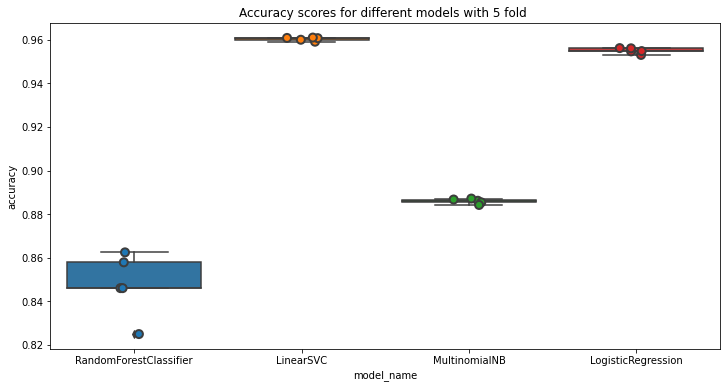

In [47]:
# Plotting accuracy score for these different models 
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='model_name', y='accuracy', data=kf_df)
sns.stripplot(x='model_name', y='accuracy', data=kf_df,  
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Accuracy scores for different models with {n} fold '.format(n = n_splits))
plt.show()

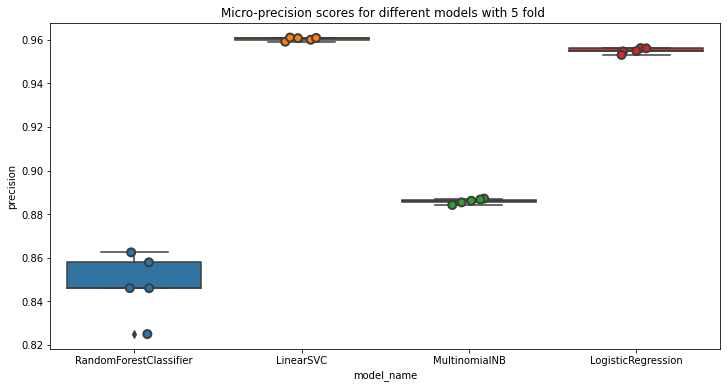

In [48]:
# Plotting Micro precision score for these different models 
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='model_name', y='precision', data=kf_df)
sns.stripplot(x='model_name', y='precision', data=kf_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Micro-precision scores for different models with {n} fold '.format(n = n_splits))
plt.show()

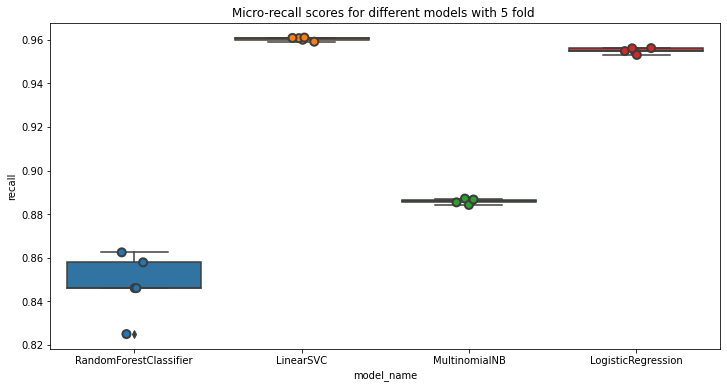

In [49]:
# Plotting Micro-recall score for these different models 
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='model_name', y='recall', data=kf_df)
sns.stripplot(x='model_name', y='recall', data=kf_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Micro-recall scores for different models with {n} fold '.format(n = n_splits))
plt.show()

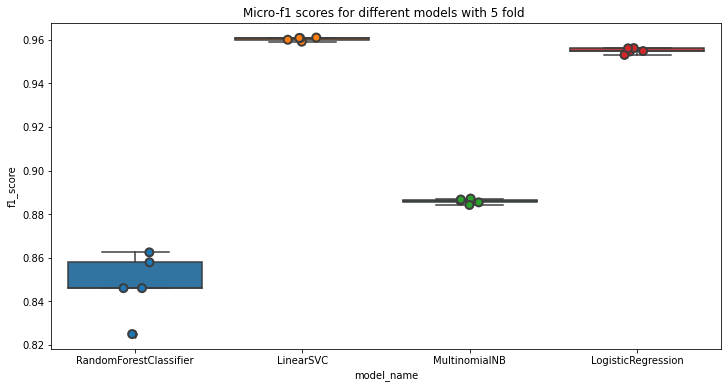

In [50]:
# Plotting Micro-f1 score for these different models 
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='model_name', y='f1_score', data=kf_df)
sns.stripplot(x='model_name', y='f1_score', data=kf_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.title('Micro-f1 scores for different models with {n} fold '.format(n = n_splits))
plt.show()

#### From above models it seems that LinearSVC model perform better than others. So, Let check confusion matrix score for it separately 

In [52]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    feature_matrix, labels, combined.index, test_size=0.2, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

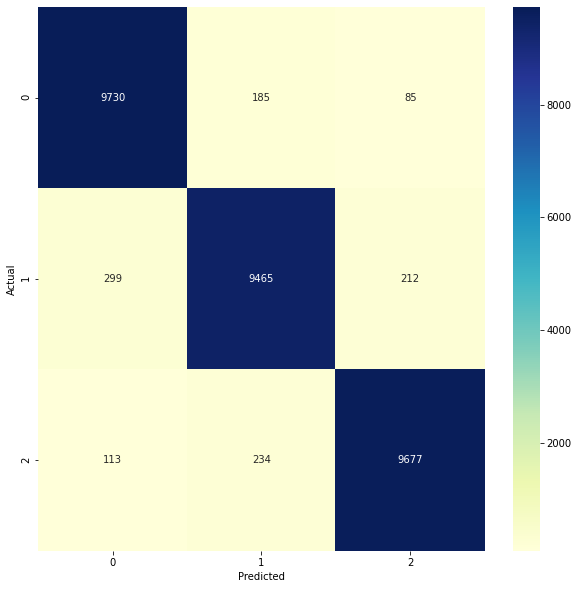

In [53]:
# Presenting confusion matrix for the model using scikit learn 
# labels 0,1,2 represent neutral, positive, and negative dataset

conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[0,1,2], yticklabels=[0,1,2], cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()